# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2018-04-30/evaluation/database internal normalisation/"
file_name = "int_norm_20180430_new_bgd.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_117/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122

# Plot raw data and check measurement

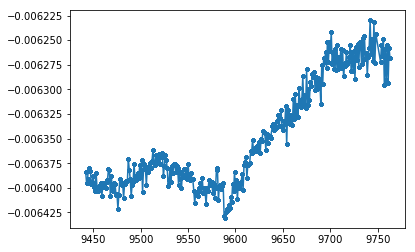

In [9]:
# Check Baselines
column = "120"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column], marker = 'o', markersize = 3)
plt.show()

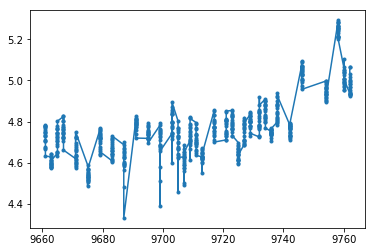

In [10]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column], marker = 'o', markersize = 3)
plt.show()

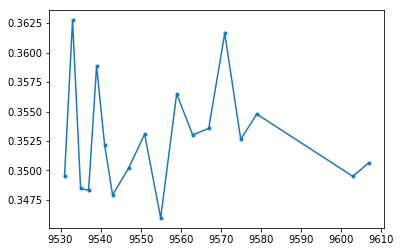

In [756]:
# Check Signals - mean
column = "117"
sample = "NIST 12ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column], marker = 'o', markersize = 3)
plt.show()

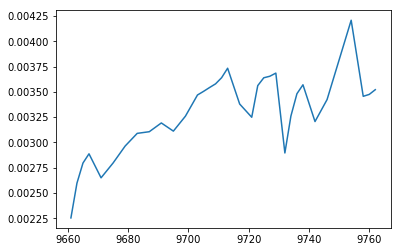

In [17]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [758]:
background_mean = df_mean(background)

# Outlier rejection

In [18]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [19]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [20]:
column = "124/118"
sample = "NIST 25 ppb"

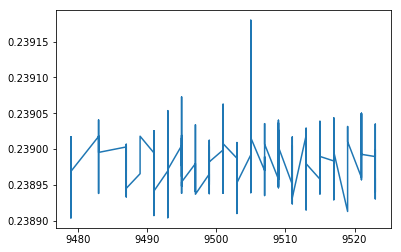

In [21]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [22]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [23]:
# Outlier removal per measurement line except for normalisation isotope pair
subset = ["117/118", "119/118", "120/118", "124/118"]
df_outlier_corr_int = df_outlier_rej_int.dropna(axis=0, how='any', subset= subset)
df_outlier_corr_raw = df_outlier_rej_raw.dropna(axis=0, how='any', subset= subset)
df_outlier_corr_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,
2018-04-30 22:18:00,NIST 8 ppb,1,2,9443,0.316585,0.354684,1.346212,0.19125,0.239031
2018-04-30 22:18:00,NIST 8 ppb,1,4,9443,0.316603,0.354677,1.346105,0.19125,0.239014
2018-04-30 22:18:00,NIST 8 ppb,1,5,9443,0.316562,0.354658,1.346314,0.19125,0.239099
2018-04-30 22:18:00,NIST 8 ppb,1,6,9443,0.316578,0.354609,1.346046,0.19125,0.238991
2018-04-30 22:18:00,NIST 8 ppb,1,7,9443,0.316558,0.354564,1.345873,0.19125,0.238942
2018-04-30 22:18:00,NIST 8 ppb,1,9,9443,0.316562,0.354608,1.346074,NaN,0.239012
2018-04-30 22:18:00,NIST 8 ppb,1,10,9443,0.316598,0.354666,1.346032,NaN,0.239002
2018-04-30 22:18:00,NIST 8 ppb,1,11,9443,0.316601,0.354669,1.346059,NaN,0.238925
2018-04-30 22:18:00,NIST 8 ppb,1,12,9443,0.316560,0.354632,1.346102,0.19125,0.239017


In [24]:
df_outlier_int = df_outlier_int.drop("122/118", axis=1)
df_outlier_int = df_outlier_int.dropna(axis=0, how='all', subset= subset)

In [25]:
df_outlier_int

117/118   119/118   120/118   124/118  Cycle  \
Filenumber Date                                                                 
9443       2018-04-30 22:18:00       NaN       NaN       NaN  0.238848      1   
           2018-04-30 22:18:00       NaN       NaN       NaN  0.239130      3   
           2018-04-30 22:18:00  0.316454       NaN       NaN  0.239151      8   
           2018-04-30 22:18:00       NaN       NaN       NaN  0.239175     19   
           2018-04-30 22:18:00       NaN       NaN       NaN  0.239150     20   
9445       2018-04-30 22:36:00       NaN       NaN  1.345766       NaN     16   
9447       2018-04-30 22:53:00       NaN       NaN  1.345784       NaN      3   
           2018-04-30 22:53:00       NaN       NaN  1.345730       NaN     14   
9451       2018-04-30 23:28:00  0.316554       NaN       NaN       NaN      6   
           2018-04-30 23:28:00  0.316729       NaN       NaN       NaN     19   
9455       2018-05-01 00:03:00       NaN  0.354492       NaN       NaN     14   
           2018-05-01 00:03:00  0.316796       NaN       NaN       NaN     20   
9463       2018-05-01 01:13:00       NaN  0.354790       NaN       NaN      6   
9465       2018-05-01 01:30:00       NaN  0.354536       NaN       NaN     16   
9469       2018-05-01 02:05:00  0.316740       NaN       NaN       NaN      9   
9475       2018-05-01 02:58:00       NaN  0.354752       NaN       NaN     16   
           2018-05-01 02:58:00       NaN  0.354540       NaN       NaN     20   
9477       2018-05-01 03:15:00       NaN  0.354592       NaN       NaN      8   
9481       2018-05-01 03:50:00       NaN       NaN  1.346335       NaN      6   
           2018-05-01 03:50:00       NaN       NaN  1.345778       NaN      9   
9487       2018-05-01 04:42:00  0.316645       NaN       NaN       NaN      1   
9491       2018-05-01 05:17:00       NaN  0.354688       NaN       NaN     13   
9493       2018-05-01 05:35:00       NaN  0.354604       NaN       NaN     14   
           2018-05-01 05:35:00       NaN  0.354596       NaN       NaN     16   
9497       2018-05-01 06:10:00  0.316650       NaN       NaN       NaN      4   
           2018-05-01 06:10:00  0.316723       NaN       NaN       NaN      6   
           2018-05-01 06:10:00  0.316726       NaN       NaN       NaN     20   
9501       2018-05-01 06:45:00  0.316657       NaN       NaN       NaN      4   
9503       2018-05-01 07:02:00       NaN       NaN       NaN  0.238910     12   
9505       2018-05-01 07:20:00  0.316873  0.354909  1.346800  0.239180     16   
...                                  ...       ...       ...       ...    ...   
9645       2018-05-02 18:16:00  0.316681  0.354589  1.345811       NaN     13   
9647       2018-05-02 18:33:00       NaN       NaN  1.346157       NaN     12   
9649       2018-05-02 18:51:00       NaN  0.354583  1.345805       NaN      7   
9651       2018-05-02 19:08:00       NaN  0.354584       NaN       NaN      4   
9653       2018-05-02 19:26:00       NaN       NaN  1.346077       NaN     13   
           2018-05-02 19:26:00       NaN       NaN  1.345879       NaN     14   
9655       2018-05-02 19:43:00       NaN       NaN  1.346080       NaN     14   
           2018-05-02 19:43:00       NaN       NaN  1.346079       NaN     16   
9675       2018-05-02 22:38:00  0.316725       NaN       NaN       NaN     19   
9683       2018-05-02 23:48:00       NaN       NaN       NaN  0.239027     14   
9685       2018-05-03 00:05:00       NaN  0.354595       NaN       NaN     11   
9687       2018-05-03 00:22:00       NaN  0.354675       NaN       NaN     19   
9689       2018-05-03 00:40:00       NaN       NaN  1.345805       NaN     16   
9697       2018-05-03 01:50:00       NaN  0.354607       NaN       NaN      1   
9701       2018-05-03 02:25:00  0.316711  0.354580       NaN       NaN     16   
9703       2018-05-03 02:42:00  0.316772       NaN       NaN       NaN     12   
           2018-05-03 02:42:00       NaN  0.354599  1.345819  0.

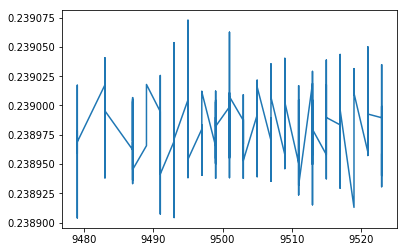

In [26]:
# Check sample measurements
df = df_outlier_corr_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [27]:
df[df["Sample"] == sample][column].std()

2.827884311213396e-05

In [28]:
data_mean_int = df_mean(df_outlier_corr_int)
data_mean_int_sd = df_SD(df_outlier_corr_int)

data_mean_raw = df_mean(df_outlier_corr_raw)
data_mean_raw_sd = df_SD(df_outlier_corr_raw)

In [29]:
sample = "NIST 12ppb"

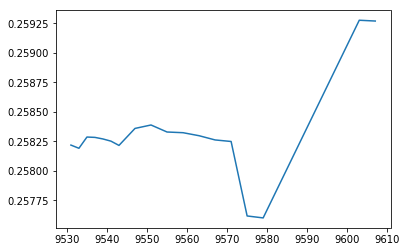

In [30]:
# Check sample measurements
df_mean_used = data_mean_raw

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


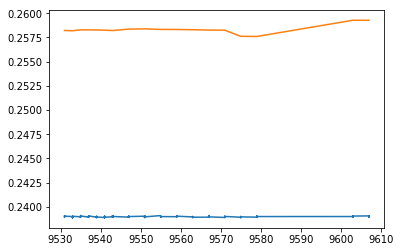

In [31]:
# Check sample measurements
df_mean_used = data_mean_int

df_int_sub = df_outlier_corr_int[df_mean_used["Sample"] == sample]
plt.plot(df_int_sub["Filenumber"], df_int_sub[column])
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

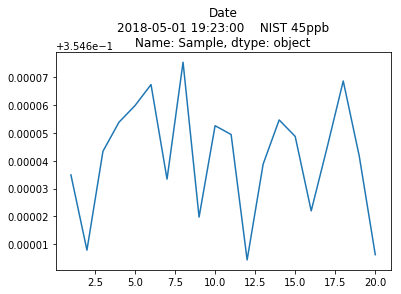

In [35]:
filenumber = 9583
isotope = "119/118"
data_single = df_outlier_corr_int[df_outlier_corr_int["Filenumber"] == filenumber]
plt.plot(data_single.Cycle, data_single[isotope])
plt.title(data_single.Sample[:1])
plt.show()

In [715]:
data_mean_raw[data_mean_raw["Sample"] == "NIST 12ppb"]

,Filenumber,Sample,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,
2018-05-01 11:44:00,9531,NIST 12ppb,0.312514,0.359337,1.383064,0.201457,0.258206
2018-05-01 12:01:00,9533,NIST 12ppb,0.312525,0.359366,1.383014,0.201467,0.258178
2018-05-01 12:19:00,9535,NIST 12ppb,0.312528,0.359368,1.383268,0.201494,0.258269
2018-05-01 12:36:00,9537,NIST 12ppb,0.312520,0.359367,1.383218,0.201493,0.258266
2018-05-01 12:54:00,9539,NIST 12ppb,0.312521,0.359375,1.383168,0.201507,0.258255
2018-05-01 13:11:00,9541,NIST 12ppb,0.312528,0.359351,1.383144,0.201498,0.258237
2018-05-01 13:29:00,9543,NIST 12ppb,0.312530,0.359350,1.383060,0.201452,0.258197
2018-05-01 14:04:00,9547,NIST 12ppb,0.312518,0.359386,1.383327,0.201545,0.258345
2018-05-01 14:39:00,9551,NIST 12ppb,0.312512,0.359379,1.383318,0.201559,0.258370


In [716]:
date_list = [pd.Timestamp("2018-05-01 19:05:00")]
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [717]:
data_mean_int_sd_stds = data_mean_int_sd[data_mean_int_sd["Sample"].isin(["NIST 8 ppb", "NIST 25 ppb", "NIST 12ppb", "NIST 45ppb", "NIST 200ppb"])]
data_mean_raw_sd_stds = data_mean_raw_sd[data_mean_raw_sd["Sample"].isin(["NIST 8 ppb", "NIST 25 ppb", "NIST 12ppb", "NIST 45ppb", "NIST 200ppb"])]

In [718]:
drop_sum = []

In [719]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [720]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [721]:
data_mean_int_sum

117/118                   119/118            \
                                mean       SD2 count      mean       SD2   
Sample                                                                     
10017,414 ns                0.316750       NaN     1  0.354743       NaN   
15016, 55 ns                0.316733       NaN     1  0.354643       NaN   
GRA06100 b.2 200ppb         0.316742       NaN     1  0.354630       NaN   
GRA06100 bomb 2 12pbb       0.316697       NaN     1  0.354647       NaN   
GRA06100 bomb 2 45ppb       0.316730       NaN     1  0.354648       NaN   
NIST 12ppb                  0.316710  0.000025    18  0.354644  0.000019   
NIST 200ppb                 0.316743  0.000007    34  0.354628  0.000005   
NIST 200ppb + 0.005 ppb U   0.316746       NaN     1  0.354632       NaN   
NIST 200ppb + 0.030 ppb Cd  0.316745       NaN     1  0.354631       NaN   
NIST 200ppb + 0.040 ppb Cd  0.316745       NaN     1  0.354633       NaN   
NIST 200ppb + 0.15 ppb Rh   0.316750       NaN     1  0.354628       NaN   
NIST 200ppb + 0.3 ppb Ru    0.316746       NaN     1  0.354634       NaN   
NIST 200ppb + 0.628 ppb Te  0.316745       NaN     1  0.354637       NaN   
NIST 200ppb + 2ppb Mo       0.316744       NaN     1  0.354629       NaN   
NIST 200ppb + ME            0.316745  0.000003     2  0.354634  0.000002   
NIST 20ppb                  0.316709  0.000017     2  0.354639  0.000020   
NIST 25 ppb                 0.316707  0.000015    21  0.354640  0.000012   
NIST 45ppb                  0.316724  0.000025    36  0.354637  0.000011   
NIST 55ppb                  0.316732  0.000004     2  0.354639  0.000011   
NIST 8 ppb                  0.316683  0.000051    22  0.354648  0.000029   
ZH09-04 23.3_3b_3           0.316725  0.000006     2  0.354636  0.000014   
ZH09-05 23.3_3b_3           0.316742       NaN     1  0.354627       NaN   
ZH09-05 23.3_3b_4 I         0.316703       NaN     1  0.354653       NaN   
ZH09-05 23.3_3b_4 II        0.316710       NaN     1  0.354654       NaN   
ZH09-05 23.3_3b_4 III       0.316692       NaN     1  0.354633       NaN   

                                   120/118                  122/118  \
                           count      mean       SD2 count     mean   
Sample                                                                
10017,414 ns                   1  1.346766       NaN     1  0.19125   
15016, 55 ns                   1  1.346374       NaN     1  0.19125   
GRA06100 b.2 200ppb            1  1.346019       NaN     1  0.19125   
GRA06100 bomb 2 12pbb          1  1.347098       NaN     1  0.19125   
GRA06100 bomb 2 45ppb          1  1.346440       NaN     1  0.19125   
NIST 12ppb                    18  1.347277  0.000301    18  0.19125   
NIST 200ppb                   34  1.346011  0.000020    34  0.19125   
NIST 200ppb + 0.005 ppb U      1  1.345998       NaN     1  0.19125   
NIST 200ppb + 0.030 ppb Cd     1  1.346008       NaN     1  0.19125   
NIST 200ppb + 0.040 ppb Cd     1  1.345995       NaN     1  0.19125   
NIST 200ppb + 0.15 ppb Rh      1  1.345992       NaN     1  0.19125   
NIST 200ppb + 0.3 ppb Ru       1  1.346005       NaN     1  0.19125   
NIST 200ppb + 0.628 ppb Te     1  1.346013       NaN     1  0.19125   
NIST 200ppb + 2ppb Mo          1  1.346008       NaN     1  0.19125   
NIST 200ppb + ME               2  1.346015  0.000001     2  0.19125   
NIST 20ppb                     2  1.346580  0.000101     2  0.19125   
NIST 25 ppb                   21  1.346570  0.000056    21  0.19125   
NIST 45ppb                    36  1.346369  0.000098    36  0.19125   
NIST 55ppb                     2  1.346289  0.000025     2  0.19125   
NIST 8 ppb                    22  1.348045  0.000130    22  0.19125   
ZH09-04 23.3_3b_3              2  1.346356  0.000066     2  0.19125   
ZH09-05 23.3_3b_3              1  1.346006       NaN     1  0.19125   
ZH09-05 23.3_3b_4 I            1  1.346872       NaN     1  0.19125   
ZH09-05 23.3_3b_4 II           1  1.347197       NaN  

In [722]:
date_list_12 = [pd.Timestamp("2018-05-02 12:02:00"),pd.Timestamp("2018-05-02 12:19:00"),pd.Timestamp("2018-05-02 12:36:00")]
date_list =[]

epsilon_int_8 = SSB(data_mean_int.drop(date_list), "NIST 8 ppb", 10000)
delta_raw_8 = SSB(data_mean_raw.drop(date_list), "NIST 8 ppb", 1000)
epsilon_int_25 = SSB(data_mean_int.drop(date_list), "NIST 25 ppb", 10000)
delta_raw_25 = SSB(data_mean_raw.drop(date_list), "NIST 25 ppb", 1000)
epsilon_int_12 = SSB(data_mean_int.drop(date_list_12), "NIST 12ppb", 10000)
delta_raw_12 = SSB(data_mean_raw.drop(date_list_12), "NIST 12ppb", 1000)
epsilon_int_45 = SSB(data_mean_int.drop(date_list), "NIST 45ppb", 10000)
delta_raw_45 = SSB(data_mean_raw.drop(date_list), "NIST 45ppb", 1000)
epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [723]:
delta_raw_200

,Filenumber,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,
2018-05-02 20:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2018-05-02 20:53:00,0.000000,-0.006558,0.017423,0.045316,0.066941,0.109033,NIST 200ppb
2018-05-02 21:10:00,0.000000,0.029611,-0.041672,-0.087717,-0.155929,-0.230807,NIST 200ppb
2018-05-02 21:28:00,-0.103434,0.008796,0.005309,0.004491,0.012624,0.008498,NIST 200ppb
2018-05-02 21:45:00,0.000000,-0.061738,0.090008,0.440942,0.323994,0.478961,NIST 45ppb
2018-05-02 22:03:00,0.000000,0.024866,-0.034566,-0.076900,-0.152590,-0.225040,NIST 200ppb
2018-05-02 22:20:00,0.000000,0.015160,-0.004116,-0.027077,-0.038948,-0.055411,NIST 200ppb + 2ppb Mo
2018-05-02 22:38:00,0.000000,-0.072682,0.070607,0.166768,0.312950,0.468584,NIST 200ppb
2018-05-02 22:55:00,0.000000,0.068991,-0.073595,-0.157366,-0.302876,-0.458397,NIST 200ppb + 0.030 ppb Cd


In [724]:

date_list = []

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [725]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -2) & (df["Filenumber"] <= 2)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df
def delta_process(df):
    df = df[(df["Filenumber"] >= -0.4) & (df["Filenumber"] <= 0.4)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [726]:
epsilon_int_8 = epsilon_process(epsilon_int_8)
delta_raw_8 = delta_process(delta_raw_8)
epsilon_int_25 = epsilon_process(epsilon_int_25)
delta_raw_25 = delta_process(delta_raw_25)
epsilon_int_12 = epsilon_process(epsilon_int_12)
delta_raw_12 = delta_process(delta_raw_12)
epsilon_int_45 = epsilon_process(epsilon_int_45)
delta_raw_45 = delta_process(delta_raw_45)
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = delta_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [727]:
epsilon_all = epsilon_int_8.append([epsilon_int_25, epsilon_int_12, epsilon_int_45, epsilon_int_200])
delta_all = delta_raw_8.append([delta_raw_25, delta_raw_12, delta_raw_45, delta_raw_200])

In [728]:
epsilon_int_8_sum = np.round(epsilon_int_8.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
delta_raw_8_sum = np.round(delta_raw_8.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
epsilon_int_25_sum = np.round(epsilon_int_25.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
delta_raw_25_sum = np.round(delta_raw_25.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
epsilon_int_12_sum = np.round(epsilon_int_12.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
delta_raw_12_sum = np.round(delta_raw_12.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
epsilon_int_45_sum = np.round(epsilon_int_45.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
delta_raw_45_sum = np.round(delta_raw_45.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=2)

epsilon_sum_all = epsilon_int_8_sum.append([epsilon_int_25_sum, epsilon_int_12_sum, epsilon_int_45_sum, epsilon_int_200_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_8_sum.append([delta_raw_25_sum, delta_raw_12_sum, delta_raw_45_sum, delta_raw_200_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [729]:
delta_raw_sum_all

117/118             119/118             120/118  \
                              mean   SD2 count    mean   SD2 count    mean   
Sample                                                                       
NIST 25 ppb                  -0.06  0.14     2    0.00  0.02     2   -1.00   
NIST 8 ppb                    0.00  0.10    18   -0.00  0.11    18   -0.00   
NIST 25 ppb                  -0.00  0.10    19    0.00  0.09    19    0.00   
NIST 8 ppb                    0.08  0.11     2   -0.01  0.00     2    1.02   
10017,414 ns                 -0.29   NaN     1    0.68   NaN     1    0.45   
GRA06100 bomb 2 12pbb        -0.44   NaN     1    0.38   NaN     1    0.67   
NIST 12ppb                   -0.00  0.13    14    0.00  0.15    14    0.00   
NIST 20ppb                    0.06  0.27     2   -0.09  0.35     2   -0.52   
NIST 45ppb                   -0.03  0.10     2    0.01  0.15     2   -0.66   
ZH09-05 23.3_3b_4 I          -0.09   NaN     1    0.07   NaN     1   -0.21   
ZH09-05 23.3_3b_4 II         -0.03   NaN     1    0.03   NaN     1   -0.01   
ZH09-05 23.3_3b_4 III        -0.07   NaN     1   -0.02   NaN     1   -0.02   
15016, 55 ns                  0.11   NaN     1   -0.11   NaN     1   -0.24   
GRA06100 bomb 2 45ppb        -0.38   NaN     1    0.40   NaN     1    0.80   
NIST 12ppb                    0.03  0.01     3    0.02  0.07     3    0.85   
NIST 200ppb                   0.03   NaN     1   -0.06   NaN     1   -0.36   
NIST 45ppb                    0.00  0.19    28   -0.00  0.19    28    0.00   
NIST 55ppb                   -0.04  0.00     2    0.02  0.02     2   -0.01   
ZH09-04 23.3_3b_3            -0.05  0.01     2    0.05  0.01     2    0.08   
GRA06100 b.2 200ppb          -0.27   NaN     1    0.27   NaN     1    0.53   
NIST 200ppb                   0.00  0.07    32   -0.00  0.07    32   -0.00   
NIST 200ppb + 0.005 ppb U     0.01   NaN     1   -0.00   NaN     1   -0.02   
NIST 200ppb + 0.030 ppb Cd    0.07   NaN     1   -0.07   NaN     1   -0.16   
NIST 200ppb + 0.040 ppb Cd    0.01   NaN     1   -0.00   NaN     1   -0.03   
NIST 200ppb + 0.15 ppb Rh     0.01   NaN     1    0.01   NaN     1    0.00   
NIST 200ppb + 0.3 ppb Ru     -0.06   NaN     1    0.07   NaN     1    0.13   
NIST 200ppb + 0.628 ppb Te   -0.04   NaN     1    0.04   NaN     1    0.07   
NIST 200ppb + 2ppb Mo         0.02   NaN     1   -0.00   NaN     1   -0.03   
NIST 200ppb + ME              0.03  0.05     2   -0.01  0.06     2   -0.04   
NIST 45ppb                   -0.04  0.04     4    0.07  0.03     4    0.37   
ZH09-05 23.3_3b_3             0.01   NaN     1   -0.00   NaN     1   -0.01   

                                       122/118             124/118              
                             SD2 count    mean   SD2 count    mean   SD2 count  
Sample                                                                          
NIST 25 ppb                 0.02     2    0.09  0.18     2    0.19  0.15     2  
NIST 8 ppb                  0.16    18   -0.00  0.31    18   -0.00  0.29    18  
NIST 25 ppb                 0.18    19    0.00  0.32    19    0.01  0.47    19  
NIST 8 ppb                  0.12     2   -0.01  0.38     2   -0.08  0.44     2  
10017,414 ns                 NaN     1    1.59   NaN     1    2.53   NaN     1  
GRA06100 bomb 2 12pbb        NaN     1    1.51   NaN     1    2.22   NaN     1  
NIST 12ppb                  0.38    14    0.01  0.68    14    0.00  0.96    14  
NIST 20ppb                  0.77     2   -0.28  1.19     2   -0.42  1.69     2  
NIST 45ppb                  0.23     2    0.07  0.33     2    0.18  0.63     2  
ZH09-05 23.3_3b_4 I          NaN     1    0.11   NaN     1    0.23   NaN     1  
ZH09-05 23.3_3b_4 II         NaN     1    0.10   NaN     1    0.08   NaN     1  
ZH09-05 23.3_3b_4 III        NaN     1    0.03   NaN     1    0.08   NaN     1  
15016, 55 ns                 NaN     1   -0.46   NaN     1   -0.68   NaN     1  
GRA06100 bomb 2 45ppb        NaN     1    1.54   NaN     1    2.27   NaN     1

In [614]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [532]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [759]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [760]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background_mean.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [746]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [747]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sd_stds.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd_stds')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sd_stds.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd_stds')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [748]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [761]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')